In [68]:
import io
import os
import json
import pandas as pd
import numpy as np
import random
import distutils.dir_util
from matplotlib import pyplot as plt

## 데이터 로드

In [69]:
data = pd.read_json('../modeling/res/train_filter.json', typ = 'frame', encoding='utf-8')

In [70]:
data.head()

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[팝],50564,1 HITS OF DECADE SPECIAL 2,"[60025, 326802, 82991, 533287, 132109, 298235,...",5,2009-07-11 21:37:42.000
1,[기분좋은],148495,100번 들어도 기분좋은 가요,"[208186, 155952, 669617, 438439, 397412, 60398...",4,2016-10-31 13:59:41.000
2,"[겨울, 크리스마스]",117162,12월의 재즈,"[407630, 235568, 352044, 294512, 309377, 17965...",353,2016-12-26 12:33:33.000
3,[발라드],151638,12월의 크리스마스를 yeah,"[290351, 404382, 18938, 676958, 374448, 62388,...",29,2009-12-22 09:11:45.000
4,[일렉],27984,1월의 최신 EDM 소식,"[34851, 596152, 650671, 16261]",84,2015-01-29 16:22:19.000


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76309 entries, 0 to 76308
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          76309 non-null  object
 1   id            76309 non-null  int64 
 2   plylst_title  76309 non-null  object
 3   songs         76309 non-null  object
 4   like_cnt      76309 non-null  int64 
 5   updt_date     76309 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.5+ MB


## EDA

- 플레이리스트 좋아요 수 

In [72]:
data['like_cnt'].describe()

count    76309.000000
mean        93.998100
std        481.666563
min          2.000000
25%          5.000000
50%         10.000000
75%         29.000000
max      53211.000000
Name: like_cnt, dtype: float64

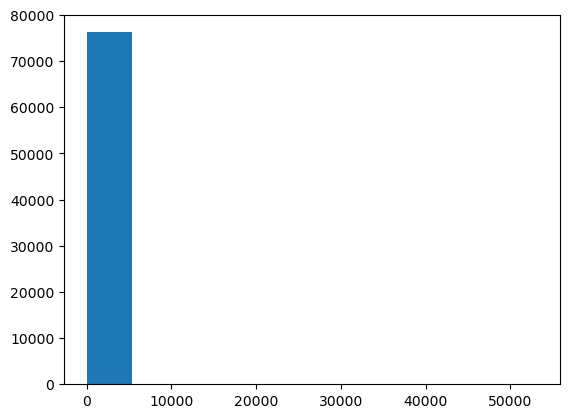

In [73]:
# 전체 Histogram
plt.hist(data['like_cnt'])
plt.show()

=> 좋아요 수의 편차가 심하다.

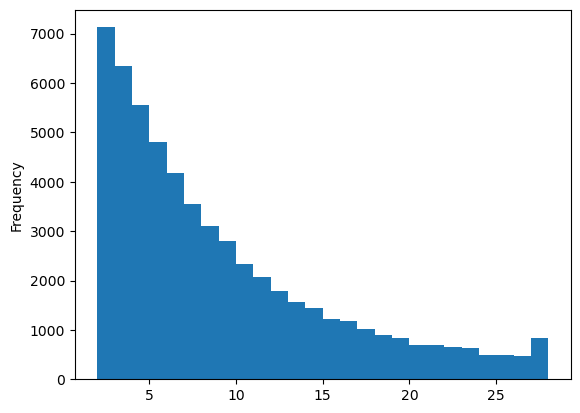

In [74]:
# 75%~ Histogram
data['like_cnt'].plot.hist(bins=range(2, 29, 1))
plt.show()

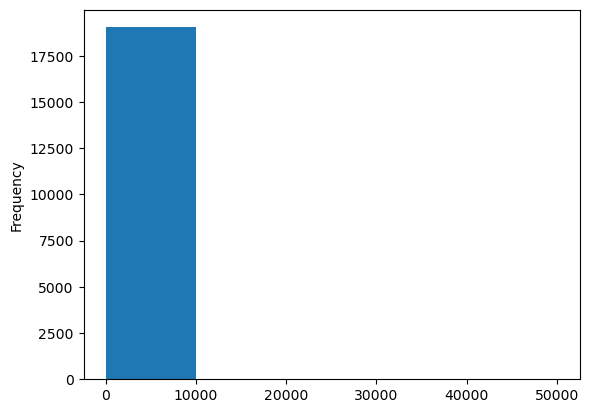

In [75]:
# ~75% Histogram
data['like_cnt'].plot.hist(bins=range(30, 53211, 10000))
plt.show()

=> 좋아요 수 25% 이하는 사람들이 사용하는 플레이리스트라고 해석하기 어렵기 때문에 해당 플레이리스트를 삭제한다.

## 데이터 전처리

### like_cnt <= 5 플레이리스트 삭제

In [76]:
df = data.copy()
len(df)

76309

In [77]:
# 하위 25% 미만은 의미가 없다고 본다.
df = df.sort_values(by=['like_cnt'],ascending=False)
df = df[df['like_cnt'] >= 5]
len(df)

57280

In [78]:
len(data) - len(df)

19029

=> 19029 개 제거로 57280개의 플레이리스트만 남음

- 데이터 저장

In [79]:
df.to_json('./data/data.json', orient='records')

## Split data

In [80]:
# json write & load 함수 정의
def write_json(data, fname):
    def _conv(o):
        if isinstance(o, (np.int64, np.int32)):
            return int(o)
        raise TypeError

    parent = os.path.dirname(fname)
    distutils.dir_util.mkpath(parent)
    with io.open(fname, "w", encoding="utf-8") as f:
        json_str = json.dumps(data, ensure_ascii=False, default=_conv)
        f.write(json_str)
        
def load_json(fname):
    with open(fname, encoding='utf-8') as f:
        json_obj = json.load(f)

    return json_obj

In [81]:
playlists = load_json('./data/data.json')

In [82]:
# 무작위로 데이터 섞기
random.seed(777)
random.shuffle(playlists)

# 80:20 비율로 split 하기
tot = len(playlists)
train = playlists[:int(tot*0.80)]
test = playlists[int(tot*0.80):]

# 데이터 확인
len(train), len(test)

(45824, 11456)

In [83]:
# 데이터 저장
write_json(train, "data/train.json")
write_json(test, "data/test.json")